## Challenge Description


The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.

They have chosen a random sample of users and emailed them. The email lets the user know about a new feature implemented on the site. From the marketing team perspective, success is if the user clicks on the link inside of the email. This link takes the user to the company site.

You are in charge of figuring out how the email campaign performed and were asked the following questions:

- What percentage of users opened the email and what percentage clicked on the link within the email?

- The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?

- By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

- Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
email = pd.read_csv('email_table.csv')
email_open = pd.read_csv('email_opened_table.csv')
email_click = pd.read_csv('link_clicked_table.csv')

In [5]:
email.head(3)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2


In [6]:
email_open.head(3)

,email_id
0,284534
1,609056
2,220820


In [7]:
email_click.head(3)

,email_id
0,609056
1,870980
2,935124


In [8]:
print(email.shape)
print(email_open.shape)
print(email_click.shape)

(100000, 7)
(10345, 1)
(2119, 1)


In [9]:
email_open['opened'] = 1
email_click['clicked'] = 1

In [10]:
# merge tables
merge = pd.merge(left = email, right=email_open, on='email_id',how='left')
merge['opened'] = merge['opened'].fillna(0)
data = pd.merge(left=merge, right=email_click, on='email_id', how='left')
data['clicked'] = data['clicked'].fillna(0)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


---

<font size=4> Question One:
    
    1. Percentage of users opened the email
    
    2. Percentage of users clicked on the link within the email

In [11]:
open_percent = data.opened.mean()*100
print('The percentage of users opened the email is: ', str(open_percent)+'%')

The percentage of users opened the email is:  10.345%


In [12]:
click_rate = data.clicked.mean()*100
print('The percentage of users clicked on the link within the email is: ', str(click_rate)+'%')

The percentage of users clicked on the link within the email is:  2.119%


---

<font size=4> Question Two:
    
    Build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email

#### Exploratory Data Analysis

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null float64
clicked                100000 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 7.6+ MB


In [14]:
num_col = ['hour','user_past_purchases']
cat_col = ['email_text','email_version','weekday','user_country']

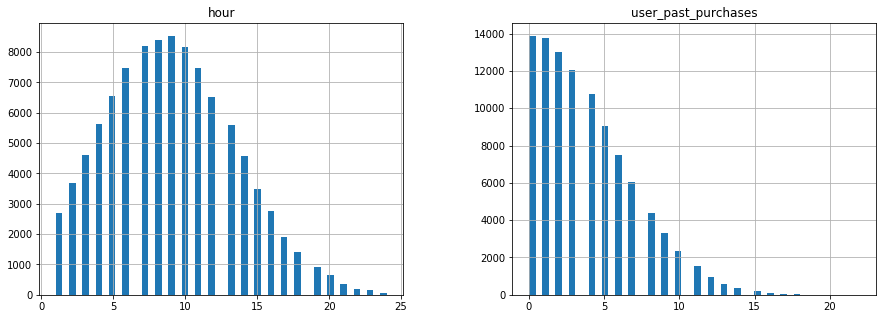

In [15]:
## distributions of the numerical variables
data[num_col].hist(bins=50,figsize=(15,5))
plt.show()

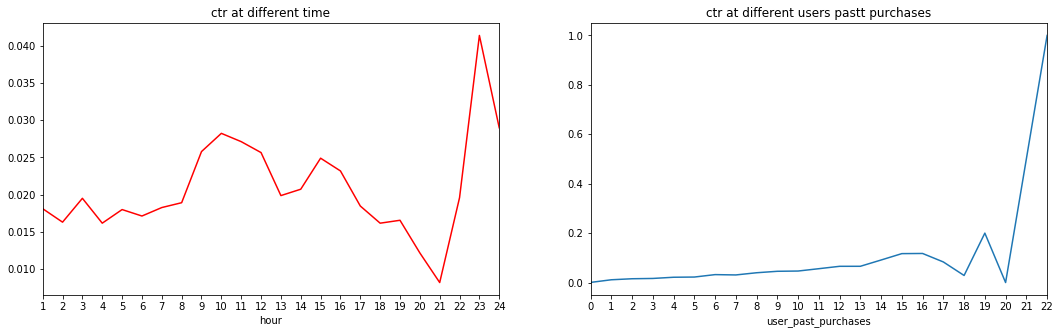

In [16]:
## plot the correlation between numerical variables and click-through-rate
fig, ax = plt.subplots(1, 2, figsize=(18,5))
chart1 = data.groupby('hour').clicked.mean().plot(kind='line', color = 'red',ax=ax[0])
chart2 = data.groupby('user_past_purchases').clicked.mean().plot(kind='line',ax=ax[1])
chart1.set_xticks(data['hour'].unique())
chart2.set_xticks(data['user_past_purchases'].unique())
chart1.set_title('ctr at different time')
chart2.set_title('ctr at different users pastt purchases')
plt.show()

<font size = 4>From the above charts, we can see that:
    
    · users are more likely to click the link within the email between 8am to 17pm
    · There is a spike clicks around the midnight, we may need to dig deeper into it
    · the more users purchases, the more likely they clicked the link

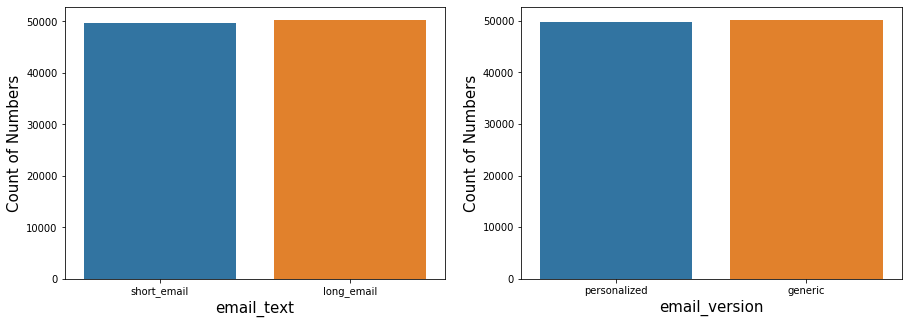

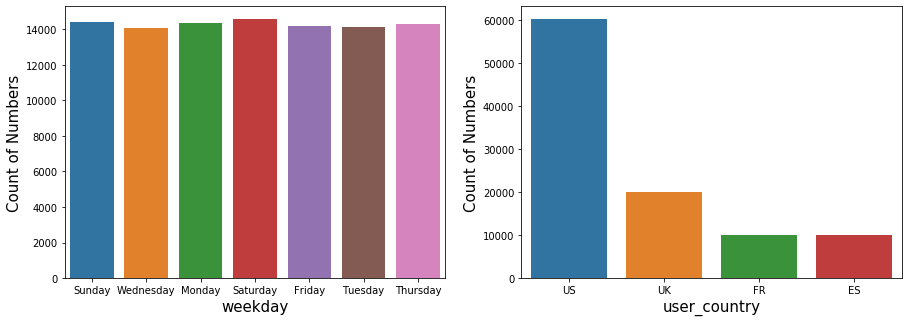

In [17]:
ncol = 2
nrow = 2
for i in range(nrow):
    fig, ax = plt.subplots(1, ncol, figsize=(15,5))
    for j in range(ncol):
        chart = sns.countplot(x=data[cat_col[i*ncol+j]], ax=ax[j])
        chart.set_xlabel(xlabel=cat_col[i*ncol+j],fontsize=15)
        chart.set_ylabel('Count of Numbers',fontsize=15)

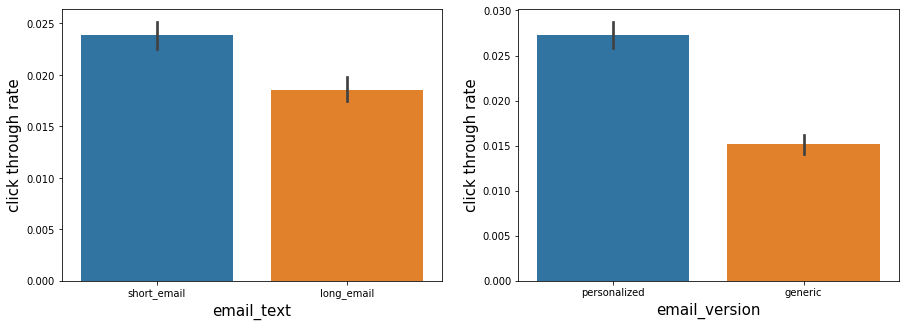

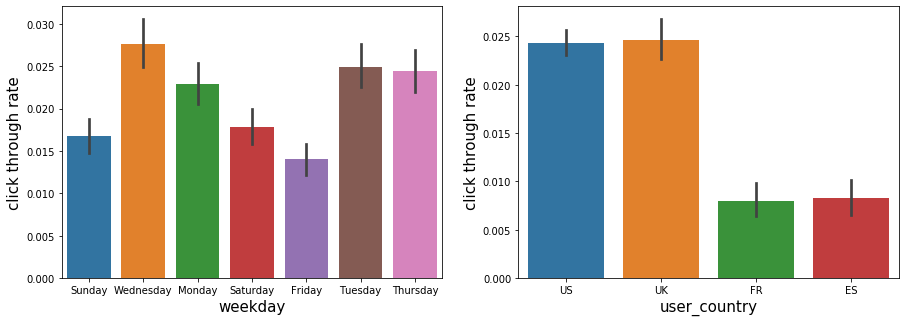

In [18]:
ncol = 2
nrow = 2
for i in range(nrow):
    fig, ax = plt.subplots(1, ncol, figsize=(15,5))
    for j in range(ncol):
        chart = sns.barplot(x=data[cat_col[i*ncol+j]], y = data['clicked'], ax=ax[j])
        chart.set_xlabel(xlabel=cat_col[i*ncol+j],fontsize=15)
        chart.set_ylabel('click through rate',fontsize=15)

<font size = 4>From the above charts, we can see that:
    
    · The number of emails sent are not comparable between different countries, there are more emails sent in US.
    · The short email has a hight ctr than long_email
    · The personalized email has a higher ctr than generic email
    · Users are more likely to click the emails on Wednesday, Tuesday and Thursday, and Friday has the lowest ctr.
    · The ctr in US and UK are higher than in FR and ES

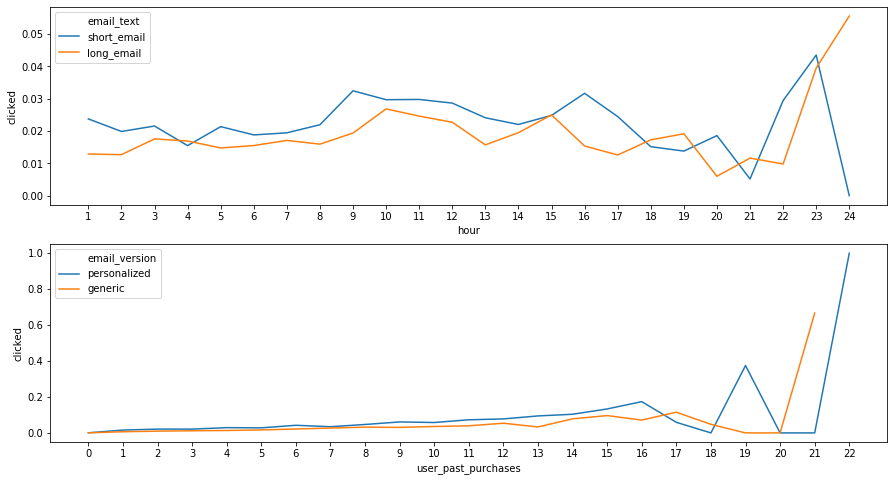

In [19]:
# The relationship between user past purchase and their click rate 
fig, ax = plt.subplots(2,1,figsize=(15,8))
sns.lineplot(x='hour',y='clicked',hue= 'email_text',data=data,ci=None,ax=ax[0])
sns.lineplot(x='user_past_purchases',y='clicked',hue='email_version',data=data, ci=None, ax=ax[1])
ax[0].set_xticks(data['hour'].unique())
ax[1].set_xticks(data['user_past_purchases'].unique())
plt.show()

<font size=4.5>Insights:
    1. It seems that after users have purchased over 20 items on the site, their open_rate and click_rate are dramatically increase.
    2. The US&UK country users have a higher click_rate than FR&ES country users.
    3. There are much more users in US market, but UK market's open_rate and click_rate are almost same as US's market. There is a huge opportunity in UK market.
    4. The short text email has a higher click_rate than long text email.
    5. The personalized email has a higher click_rate than general email.
    6. The highest click rate in local hour is around 23, but the sent email numbers at local time 23 is pretty low.

---

### Building Model

In [20]:
data['clicked'] = data['clicked'].astype(int)
data['opened'] = data['opened'].astype(int)
data.head(3)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0


#### Dummy variables

In [21]:
data_dummy = pd.get_dummies(data, drop_first=True)
X = data_dummy.drop(['email_id','clicked','opened'],axis=1)
y = data_dummy['clicked']

#### Developing model and fit trainning dataset

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
# data imbalance
print ('No click:',data.clicked.value_counts()[0])
print ("Click:",data.clicked.value_counts()[1])
print ('Bias:',str(round(data.clicked.value_counts()[1] / data.clicked.value_counts()[0] * 100,2))+'%')

No click: 97881
Click: 2119
Bias: 2.16%


In [25]:
rfc = RandomForestClassifier(n_estimators=100, max_depth = 10, oob_score=True, class_weight={0:1,1:10})

In [26]:
rfc = rfc.fit(X_train,y_train)

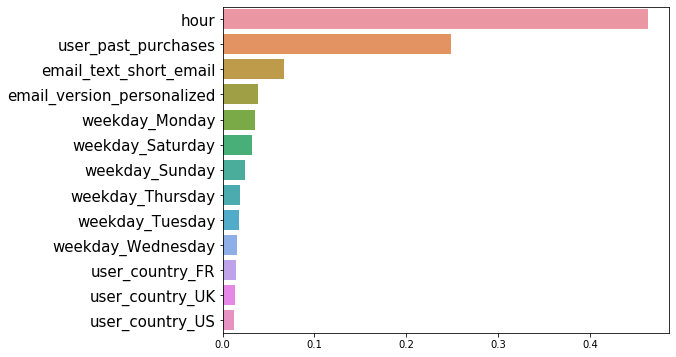

In [27]:
features = X.columns
plt.figure(figsize=(8,6))
sns.barplot(x=sorted(rfc.feature_importances_, reverse=True),y=features)
plt.yticks(fontsize=15)
plt.show()

<font size=5>
    
    We can see that hour and user_past_purchases are the most important feature to convert customers, but it makes sense that people are sleeping on nights and the more users buy the more they are likely to click the link. let's remove hour and user_past_purchases to re-train the model.

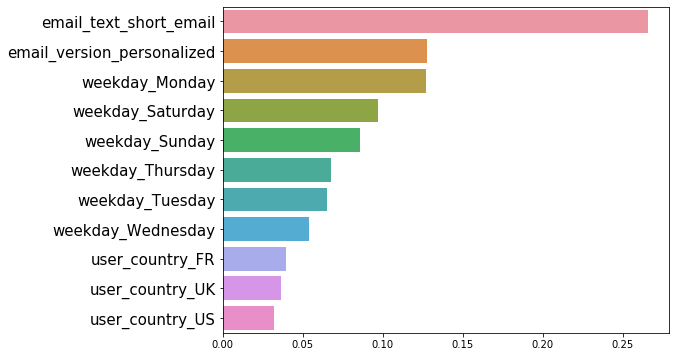

In [28]:
RF = RandomForestClassifier(n_estimators=100, max_depth = 10, oob_score=True, class_weight={0:1,1:10})
RF.fit(X_train.drop(['hour','user_past_purchases'],axis=1),y_train)
features = X.columns.drop(['hour','user_past_purchases'])
plt.figure(figsize=(8,6))
sns.barplot(x=sorted(RF.feature_importances_, reverse=True),y=features)
plt.yticks(fontsize=15)
plt.show()

<font size=5>
    
    Now, we can see that email_text_short_email is the most important feature to convert customers.

#### Model Evaluation

In [32]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# train dataset
print('Training dataset:\n', rfc.oob_score_)
print(confusion_matrix(y_train, rfc.oob_decision_function_[:,1].round()))
print('-'*30)
# test dataset
print('Testing dataset:\n',rfc.score(X_test, y_test))
print(confusion_matrix(y_test, rfc.predict(X_test)))

Training dataset:
 0.9769857142857142
[[68372   134]
 [ 1477    17]]
------------------------------
Testing dataset:
 0.9778666666666667
[[29329    46]
 [  618     7]]


#### Plot ROC, AUC curves

In [33]:
# predict probabilities
train_probs = rfc.predict_proba(X_train)
test_probs = rfc.predict_proba(X_test)

# get fpr, tpr info
train_fpr, train_tpr, train_thred = metrics.roc_curve(y_train.values,train_probs[:,1])
test_fpr, test_tpr, test_thred = metrics.roc_curve(y_test.values,test_probs[:,1])

# calculate auc
roc_auc_train = round(metrics.auc(train_fpr, train_tpr),3)
roc_auc_test = round(metrics.auc(test_fpr, test_tpr),3)
print (roc_auc_train)
print (roc_auc_test)

0.865
0.733


In [34]:
# The Geometric Mean or G-Mean is a metric for imbalanced classification that, 
# if optimized, will seek a balance between the sensitivity and the specificity.

gmeans = np.sqrt(train_tpr * (1-train_fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (train_thred[ix], gmeans[ix]))

Best Threshold=0.199688, G-Mean=0.780


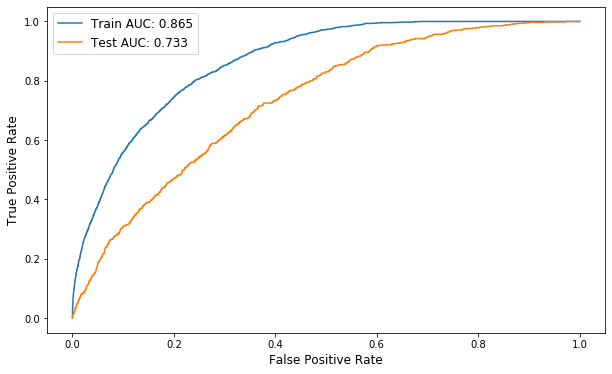

In [35]:
# ROC_AUC Curve
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(train_fpr, train_tpr,label='Train AUC: ' + str(roc_auc_train))
ax.plot(test_fpr, test_tpr,label='Test AUC: ' + str(roc_auc_test))
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize = 12)
ax.legend(fontsize=12)
plt.show()

---

<font size=4> Question Three

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link.

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.

1. Randomly assign users to two groups, Control group and Experiment group.
2. In Control group, still use the old email-campaign strategy, i.e., just send emails to users randomly.
3. In Experiment group, use the model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
4. Preform a one-tail unpaired t-test to test whether Experiement group's click-through-rate is higher than Control group's.

---

<font size=4>Question 4: 
    
    Any interesting pattern on how the email campaign performed for different segments of users

<font size=4>
From the above results:
    
    Users perform differently on different segments:
       - The more users purchase, the more likely they tend to click the link. I recommend focusing on existing users to send emails regularly to keep them retained.
       - Users are more likely to click in a personalized email than a generilized one. Conduct an AB test to validate the correlation, if it is statistically significant, do personalized email campaign.
       - Users are more likely to click the link in a short text email. Conduct an AB test experiment to validate the correlation.
       - Users in US and UK have a higher click through rate, but we send few emails to UK users. Try do more email campaigns in UK region, since this could be a growth opportunity.
       - decrease the frequency of sending emails on Friday and weekends, the click through rate on these days are lower than other days.